# パッケージインストール

In [1]:
!pip install -q transformers==4.45.1
!pip install -q accelerate==0.34.2
!pip install -q huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207

# HuggingFace アクセスキー設定

In [2]:
from google.colab import userdata
from huggingface_hub import login

login(token=userdata.get("HF_KEY"))

# サンプル画像ダウンロード

In [15]:
!wget https://user0514.cdnw.net/shared/img/thumb/kyotoPAKE0480_TP_V4.jpg -O sample.jpg

--2025-03-01 07:12:20--  https://user0514.cdnw.net/shared/img/thumb/kyotoPAKE0480_TP_V4.jpg
Resolving user0514.cdnw.net (user0514.cdnw.net)... 172.233.66.71
Connecting to user0514.cdnw.net (user0514.cdnw.net)|172.233.66.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45329 (44K) [image/jpeg]
Saving to: ‘sample01.jpg’

sample01.jpg        100%[===================>]  44.27K   178KB/s    in 0.2s    

2025-03-01 07:12:21 (178 KB/s) - ‘sample01.jpg’ saved [45329/45329]



# モデル読み込み

In [16]:
# モデル選択
model_path = "MIL-UT/Asagi-2B"  # T4 GPU
# model_path = "MIL-UT/Asagi-4B"  # T4 GPU
# model_path = "MIL-UT/Asagi-8B"  # L4 GPU
# model_path = "MIL-UT/Asagi-14B"  # A100 GPU

In [17]:
import torch
import transformers
from transformers import AutoModel, AutoProcessor

transformers.set_seed(42)

processor = AutoProcessor.from_pretrained(model_path)

model = AutoModel.from_pretrained(
    model_path, trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# プロンプト生成

In [18]:
import requests
from PIL import Image
from transformers import GenerationConfig

prompt = ("""
以下は、タスクを説明する指示です。要求を適切に満たす応答を書きなさい。

### 指示:
<image>
この画像を見て、次の質問に詳細かつ具体的に答えてください。
この写真はどこで撮影されたものか教えてください。
また、画像の内容についても詳しく説明してください。

### 応答:
""")

image = Image.open("sample.jpg")

inputs = processor(
    text=prompt, images=image, return_tensors="pt"
)
inputs_text = processor.tokenizer(prompt, return_tensors="pt")
inputs['input_ids'] = inputs_text['input_ids']
inputs['attention_mask'] = inputs_text['attention_mask']
for k, v in inputs.items():
    if v.dtype == torch.float32:
        inputs[k] = v.to(model.dtype)
inputs = {k: inputs[k].to(model.device) for k in inputs if k != "token_type_ids"}

generation_config = GenerationConfig(
    do_sample=True,
    num_beams=5,
    max_new_tokens=256,
    temperature=0.7,
    repetition_penalty=1.5
)

# 推論

In [19]:
%%time

generate_ids = model.generate(
    **inputs,
    generation_config=generation_config
)
generated_text = processor.batch_decode(
    generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]

if "<image>" in prompt:
    prompt = prompt.replace("<image>", " ")
generated_text = generated_text.replace(prompt, "")

CPU times: user 1min 23s, sys: 1.17 s, total: 1min 24s
Wall time: 1min 24s


# 結果確認

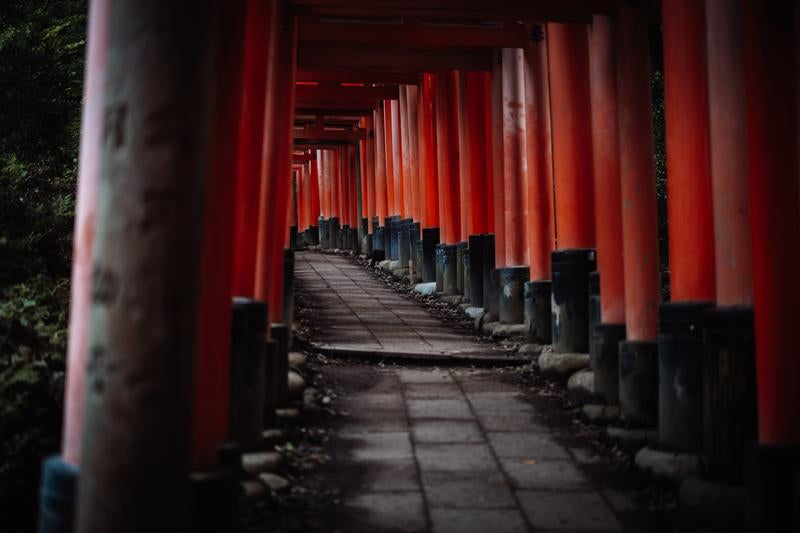

In [22]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('sample.jpg')
cv2_imshow(image)

In [20]:
import textwrap

print(textwrap.fill(generated_text, width=50))

 この写真は、伏見稲荷大社の赤い鳥居が並ぶ小道を撮影したものです。小道は石畳で、周囲には緑豊かな自然
が広がっています。鳥居は鮮やかな赤色で、神聖な雰囲気を醸し出しています。
